In [21]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# File paths
files = {
    "benign": r"C:\Users\User\Documents\VS_Code\Cancer_Project\Prediction_result\benign_predictions.txt",
    "malignant": r"C:\Users\User\Documents\VS_Code\Cancer_Project\Prediction_result\malignant_predictions.txt",
    "invalid": r"C:\Users\User\Documents\VS_Code\Cancer_Project\Prediction_result\invalid_predictions.txt"
}

In [ ]:
def parse_predictions(file_path, true_label):
    """Parses the prediction file and returns a DataFrame."""
    data = []
    
    with open(file_path, 'r') as f:
        for line in f:
            match = re.match(r"(.+?): Classified as (.+?) with confidence ([0-9\.]+)", line.strip())
            if match:
                filename, prediction, confidence = match.groups()
                confidence = float(confidence)
                misclassified = prediction != true_label
                data.append([filename, prediction, confidence, misclassified, true_label])
    
    df = pd.DataFrame(data, columns=["Image", "Prediction", "Confidence", "Misclassified", "True Label"])
    return df

In [27]:
# Process files
dfs = {}
for label, file_path in files.items():
    dfs[label] = parse_predictions(file_path, label.capitalize() if label != "invalid" else "Invalid Image")

In [32]:
# Analyze results
def analyze_df(df, label):
    print(f"\nAnalysis for {label} Images:")
    print(df.head())
    total_images = len(df)
    misclassified_images = df['Misclassified'].sum()
    accuracy = (total_images - misclassified_images) / total_images * 100
    print("Total images:", total_images)
    print("Misclassified images:", misclassified_images)
    print(f"Accuracy: {accuracy:.2f}%")
    print("Confidence distribution:")
    print(df['Confidence'].describe())
    print("Classification distribution:")
    print(df['Prediction'].value_counts())
    
    return misclassified_images, accuracy

In [29]:
misclassified_counts = {}
accuracy_per_class = {}
for label, df in dfs.items():
    misclassified_counts[label], accuracy_per_class[label] = analyze_df(df, label)


Analysis for benign Images:
               Image Prediction  Confidence  Misclassified True Label
0     melanoma_0.jpg     Benign         1.0          False     Benign
1     melanoma_1.jpg     Benign         1.0          False     Benign
2    melanoma_10.jpg     Benign         1.0          False     Benign
3   melanoma_100.jpg     Benign         1.0          False     Benign
4  melanoma_1000.jpg     Benign         1.0          False     Benign
Total images: 5000
Misclassified images: 175
Accuracy: 96.50%
Confidence distribution:
count    5000.000000
mean        0.965624
std         0.081422
min         0.500000
25%         0.980000
50%         1.000000
75%         1.000000
max         1.000000
Name: Confidence, dtype: float64
Classification distribution:
Prediction
Benign           4825
Invalid Image     155
Malignant          20
Name: count, dtype: int64
Filtered Confidence distribution (above 0.50):
count    4999.000000
mean        0.965717
std         0.081163
min         0.510000


In [68]:
# Scatter plot function for each prediction category with separate legend
def plot_scatter_for_predictions(df, category):
    plt.figure(figsize=(10, 6))
    colors = {
        ("Benign", "Benign"): "green",  # Correctly classified as Benign
        ("Benign", "Malignant"): "red",  # Misclassified as Malignant
        ("Benign", "Invalid Image"): "blue",  # Misclassified as Invalid
        ("Malignant", "Benign"): "green",  # Misclassified as Benign
        ("Malignant", "Malignant"): "red",  # Correctly classified as Malignant
        ("Malignant", "Invalid Image"): "blue",  # Misclassified as Invalid
        ("Invalid Image", "Benign"): "green",  # Misclassified as Benign
        ("Invalid Image", "Malignant"): "red",  # Misclassified as Malignant
        ("Invalid Image", "Invalid Image"): "blue",  # Correctly classified as Invalid
    }
    df["Color"] = df.apply(lambda x: colors.get((x["True Label"], x["Prediction"]), "gray"), axis=1)
    
    # Create scatter plot
    plt.scatter(df.index, df['Confidence'], c=df['Color'], alpha=0.6)
    plt.xlabel("Image Index")
    plt.ylabel("Confidence Score")
    plt.title(f"Confidence vs Misclassified Images ({category})")
    
    # Create category-specific legend
    category_legends = {
        "Benign": {
            "Correctly Classified": "green",
            "Misclassified as Malignant": "red",
            "Misclassified as Invalid": "blue"
        },
        "Malignant": {
            "Correctly Classified": "red",
            "Misclassified as Benign": "green",
            "Misclassified as Invalid": "blue"
        },
        "Invalid Image": {
            "Correctly Classified": "blue",
            "Misclassified as Benign": "green",
            "Misclassified as Malignant": "red"
        }
    }
    legend_labels = category_legends.get(category, {})
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels.items()]
    plt.legend(handles=legend_handles, title="Legend")
    plt.show()

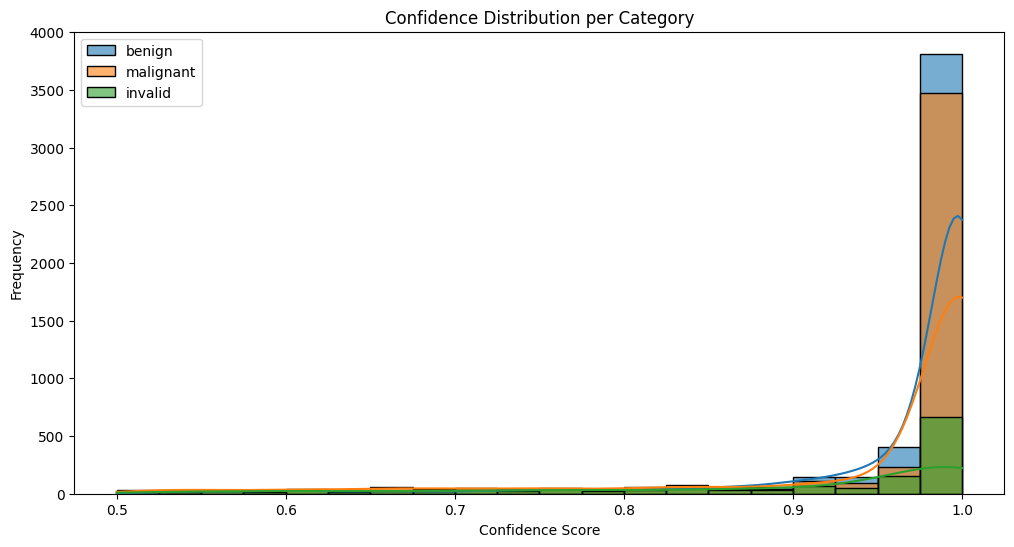

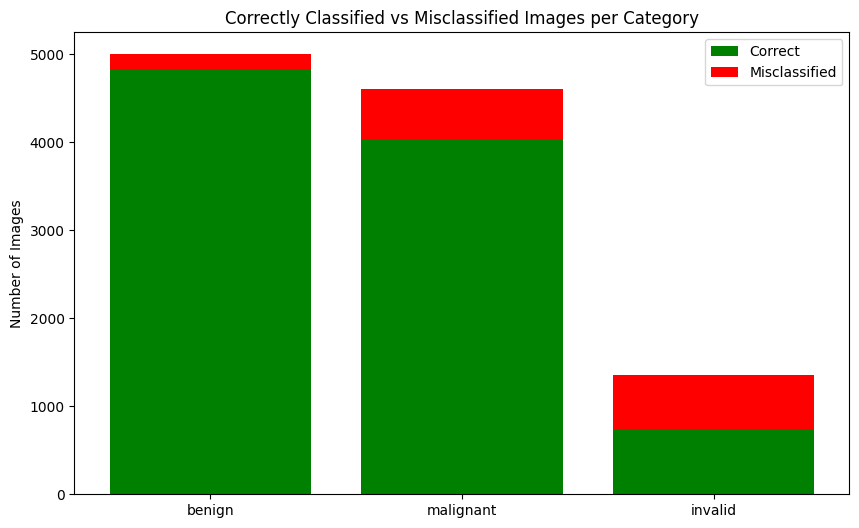

In [69]:
# Confidence distribution plot
plt.figure(figsize=(12, 6))
for label, df in dfs.items():
    sns.histplot(df['Confidence'], bins=20, kde=True, label=label, alpha=0.6)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Distribution per Category")
plt.legend()
plt.show()

# Plot classified vs misclassified for each category
plt.figure(figsize=(10,6))
for label, df in dfs.items():
    correct = len(df) - df['Misclassified'].sum()
    incorrect = df['Misclassified'].sum()
    plt.bar(label, correct, color='green', label='Correct' if label == 'benign' else "")
    plt.bar(label, incorrect, bottom=correct, color='red', label='Misclassified' if label == 'benign' else "")
plt.ylabel("Number of Images")
plt.title("Correctly Classified vs Misclassified Images per Category")
plt.legend()
plt.show()

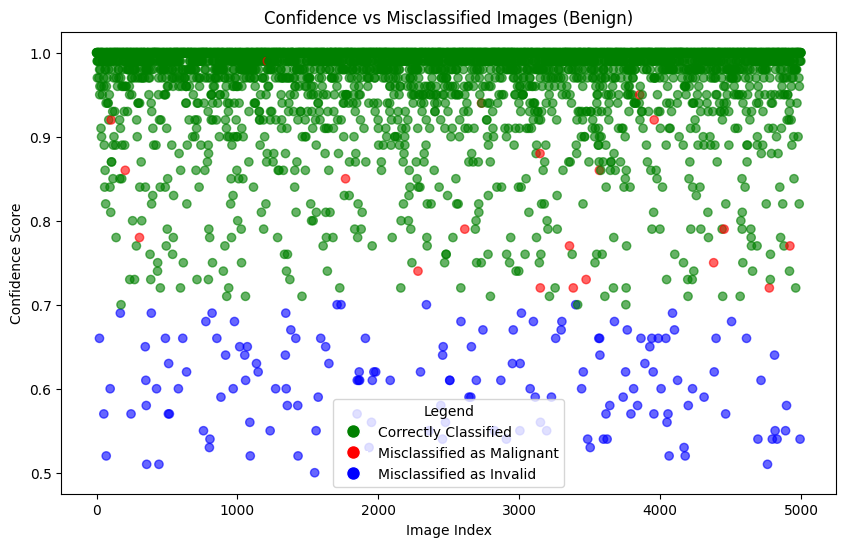

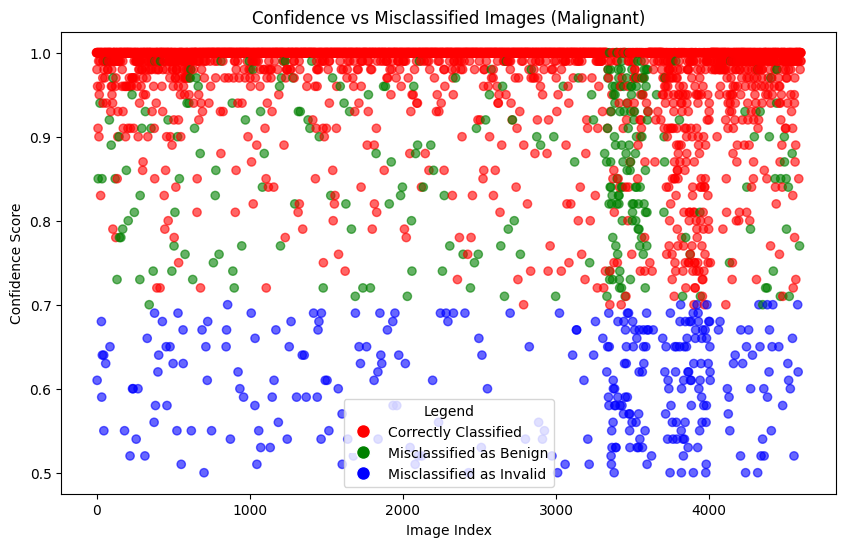

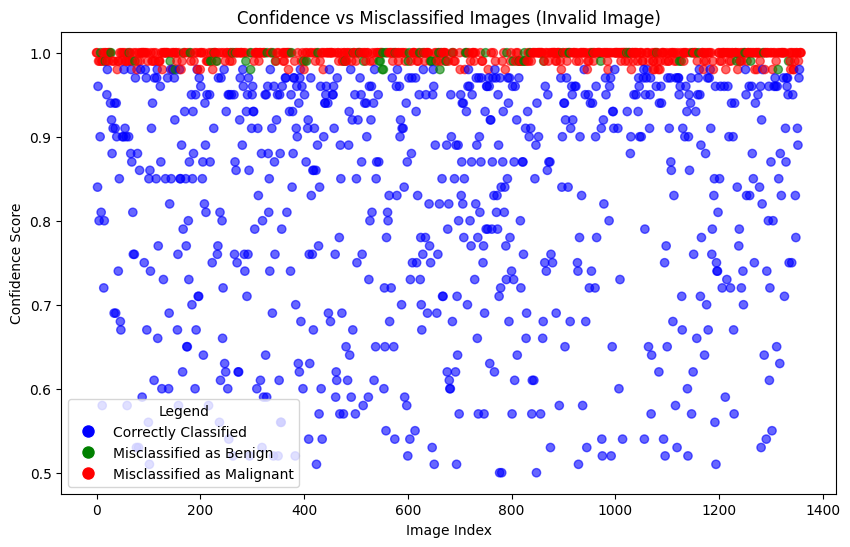

In [70]:
# Generate scatter plots for each prediction file
for label, df in dfs.items():
    plot_scatter_for_predictions(df, label.capitalize() if label != "invalid" else "Invalid Image")

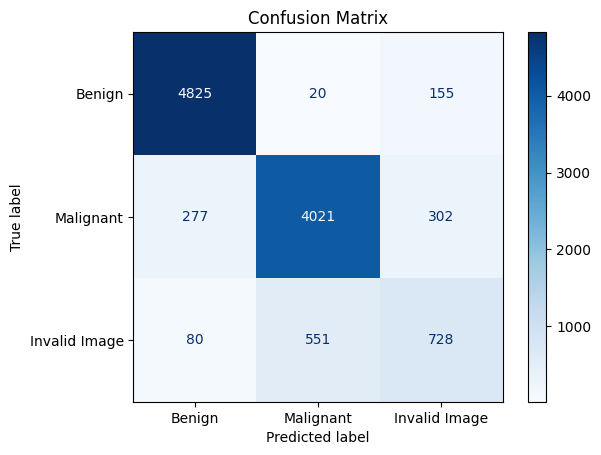

In [71]:
# Confusion matrix
all_predictions = []
all_true_labels = []
for df in dfs.values():
    all_predictions.extend(df["Prediction"].values)
    all_true_labels.extend(df["True Label"].values)

cm = confusion_matrix(all_true_labels, all_predictions, labels=["Benign", "Malignant", "Invalid Image"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant", "Invalid Image"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [38]:
# Print accuracy per class
print("\nModel Accuracy per Class:")
for label, accuracy in accuracy_per_class.items():
    print(f"{label.capitalize()} Accuracy: {accuracy:.2f}%")


Model Accuracy per Class:
Benign Accuracy: 96.50%
Malignant Accuracy: 87.41%
Invalid Accuracy: 53.57%
